# DataCamp Code-along - Dataset creation

❤️ Created by [@maximelabonne](https://twitter.com/maximelabonne) as part of the 🗣️ [Large Language Model Course](https://github.com/mlabonne/llm-course).

You can run this notebook on a free-tier Google Colab (T4 GPU).

## 1. Introduction

High-quality data is fundamental to produce a good model. The higher the quality, the better the model. In this notebook, we will create a dataset for fine-tuning LLMs.

![](https://i.imgur.com/IDNhAWH.png)

There are different types of datasets we can use to fine-tune LLMs:

1. **Instruction datasets**: inputs are instructions (e.g., questions) and outputs correspond to the expected responses (e.g., answers). *Example: Open-Orca.*
2. **Raw completion**: this is a continuation of the pre-training objective (next token prediction). In this case, the trained model is not designed to be used as an assistant. *Example: MADLAD-400.*
3. **Preference datasets**: these datasets are used with reinforcement learning to rank candidate responses. They can provide multiple answers to the same instruction, and help the model to select the best response. *Example: ultrafeedback_binarized.*
4. **Others**: a fill-in-the-middle objective is very popular with code completion models (e.g., Codex from GitHub Copilot). Other datasets can be designed for classification, where the outputs correspond to the labels we want to predict (the model requires an additional classfication head in this case).

In practice, supervised fine-tuning only leverages the first type of dataset. We can either **create our own** instruction dataset or **modify an existing one** to filter, improve, or enrich it.

## 2. Load and analyze the dataset

In this notebook, we will filter the excellent [Open-Platypus dataset](https://huggingface.co/datasets/garage-bAInd/Open-Platypus). It's already a collection of different datasets:

| Dataset Name                                                 | License Type |
|--------------------------------------------------------------|--------------|
| [PRM800K](https://github.com/openai/prm800k)                 | MIT          |
| [ScienceQA](https://github.com/lupantech/ScienceQA) | [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)    |
| [SciBench](https://github.com/mandyyyyii/scibench)    | MIT      |
| [ReClor](https://whyu.me/reclor/)                            | Non-commercial      |
| [TheoremQA](https://huggingface.co/datasets/wenhu/TheoremQA) | MIT      |
| [`nuprl/leetcode-solutions-python-testgen-gpt4`](https://huggingface.co/datasets/nuprl/leetcode-solutions-python-testgen-gpt4/viewer/nuprl--leetcode-solutions-python-testgen-gpt4/train?p=1) | None listed |
| [`jondurbin/airoboros-gpt4-1.4.1`](https://huggingface.co/datasets/jondurbin/airoboros-gpt4-1.4.1) | other |
| [`TigerResearch/tigerbot-kaggle-leetcodesolutions-en-2k`](https://huggingface.co/datasets/TigerResearch/tigerbot-kaggle-leetcodesolutions-en-2k/viewer/TigerResearch--tigerbot-kaggle-leetcodesolutions-en-2k/train?p=2) | apache-2.0 |
| [openbookQA](https://huggingface.co/datasets/openbookqa/viewer/additional/train?row=35) | apache-2.0      |
| [ARB](https://arb.duckai.org)                                | MIT      |
| [`timdettmers/openassistant-guanaco`](https://huggingface.co/datasets/timdettmers/openassistant-guanaco)                                | apache-2.0      |

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import os

from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
from datasets import Dataset, DatasetDict, load_dataset
from tqdm.autonotebook import tqdm


You can find your token at this address: https://huggingface.co/settings/tokens and copy paste it in the "Secrets" tab in Google Colab (name: "huggingface").

In [3]:
# from google.colab import userdata

# # Defined in the secrets tab in Google Colab
# hf_token = userdata.get('huggingface')

In [4]:
# Load the dataset
dataset = load_dataset("garage-bAInd/Open-Platypus")
dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'data_source'],
        num_rows: 24926
    })
})

In [5]:
# Read as pandas DataFrame
dataset['train'].to_pandas()

,input,output,instruction,data_source
0,,To find the probability of the spinner landing...,A board game spinner is divided into three par...,MATH/PRM-800K
1,,"I need to choose 6 people out of 14, and the o...",My school's math club has 6 boys and 8 girls. ...,MATH/PRM-800K
2,,First we count the number of all 4-letter word...,How many 4-letter words with at least one cons...,MATH/PRM-800K
3,,She can do this if and only if at least one of...,Melinda will roll two standard six-sided dice ...,MATH/PRM-800K
4,,Think of the problem as a sequence of H's and ...,"Let $p$ be the probability that, in the proces...",MATH/PRM-800K
...,...,...,...,...
24921,,There are several formulas that generate all p...,Can we find a formula to generate all prime nu...,guanaco
24922,,"Sure, here are some of the best universities:\...",What are some of the best university's for stu...,guanaco
24923,,[Enter stage left]\n\nFirst Citizen: Good morr...,Write me a SPL (Shakespeare Programming Langua...,guanaco
24924,,That's a very thoughtful idea! Here are some s...,Hi. I want to make an embossed picture for my ...,guanaco


In [8]:
# 1. Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf")

# 2. Tokenize each row and count the number of tokens
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

instruction_token_counts[0], output_token_counts[0], combined_token_counts[0]

(85, 223, 308)

In [9]:
print(dataset['train'][0]["instruction"])
print(len(dataset['train'][0]["instruction"])) #count of characters in the text
print(tokenizer.tokenize(dataset['train'][0]["instruction"]))
print(len(tokenizer.tokenize(dataset['train'][0]["instruction"]))) # count of tokens
dataset['train'][0]["instruction"]

A board game spinner is divided into three parts labeled $A$, $B$  and $C$. The probability of the spinner landing on $A$ is $\frac{1}{3}$ and the probability of the spinner landing on $B$ is $\frac{5}{12}$.  What is the probability of the spinner landing on $C$? Express your answer as a common fraction.
305
['▁A', '▁board', '▁game', '▁sp', 'inner', '▁is', '▁divided', '▁into', '▁three', '▁parts', '▁l', 'abeled', '▁$', 'A', '$,', '▁$', 'B', '$', '▁', '▁and', '▁$', 'C', '$.', '▁The', '▁probability', '▁of', '▁the', '▁sp', 'inner', '▁landing', '▁on', '▁$', 'A', '$', '▁is', '▁$\\', 'frac', '{', '1', '}{', '3', '}$', '▁and', '▁the', '▁probability', '▁of', '▁the', '▁sp', 'inner', '▁landing', '▁on', '▁$', 'B', '$', '▁is', '▁$\\', 'frac', '{', '5', '}{', '1', '2', '}$.', '▁', '▁What', '▁is', '▁the', '▁probability', '▁of', '▁the', '▁sp', 'inner', '▁landing', '▁on', '▁$', 'C', '$?', '▁Express', '▁your', '▁answer', '▁as', '▁a', '▁common', '▁fraction', '.']
85


'A board game spinner is divided into three parts labeled $A$, $B$  and $C$. The probability of the spinner landing on $A$ is $\\frac{1}{3}$ and the probability of the spinner landing on $B$ is $\\frac{5}{12}$.  What is the probability of the spinner landing on $C$? Express your answer as a common fraction.'

In [10]:
# Helper function to plot the distributions
def plot_distribution(token_counts, title):
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 6))
    plt.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Number of tokens", fontsize=14)
    plt.ylabel("Number of examples", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

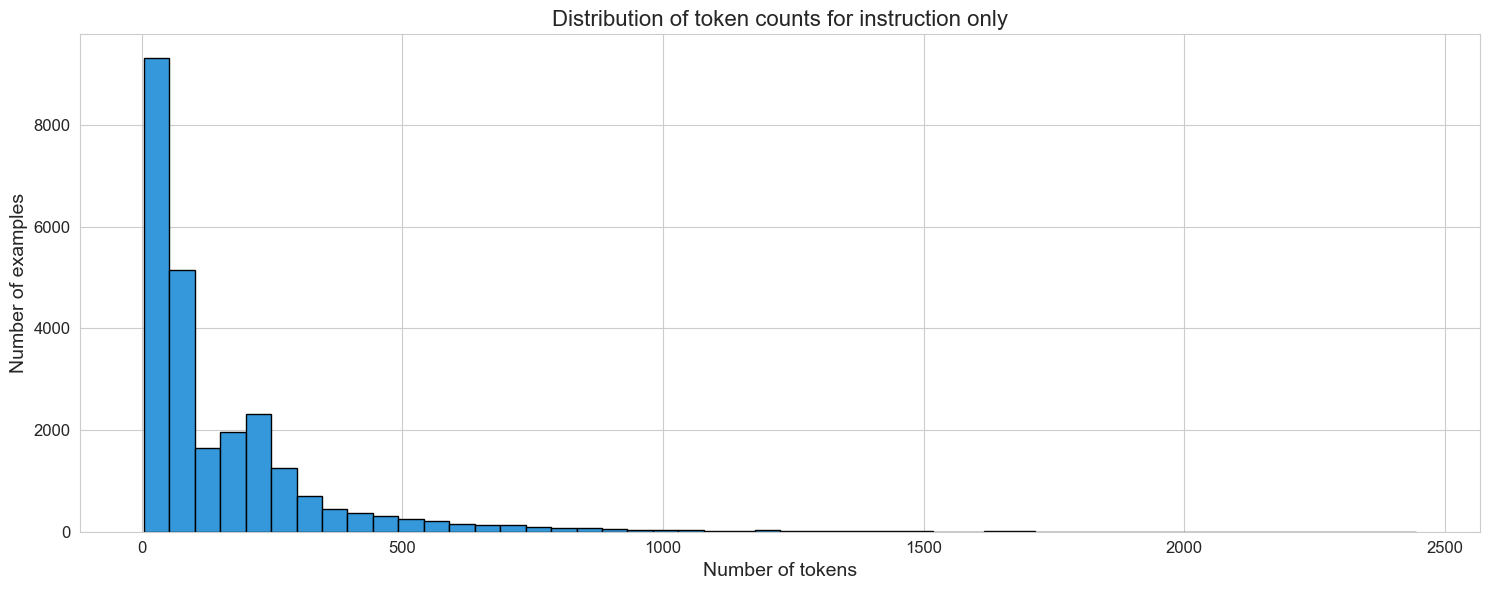

In [11]:
# Plot the distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")


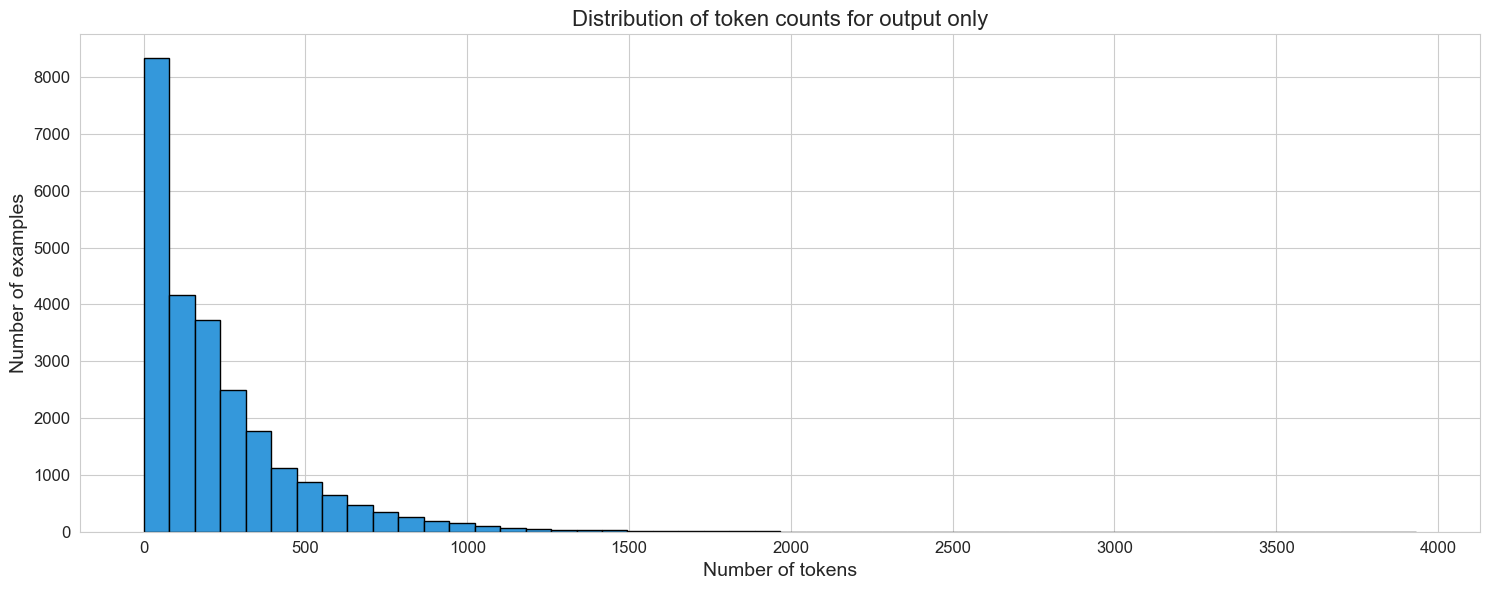

In [12]:
plot_distribution(output_token_counts, "Distribution of token counts for output only")

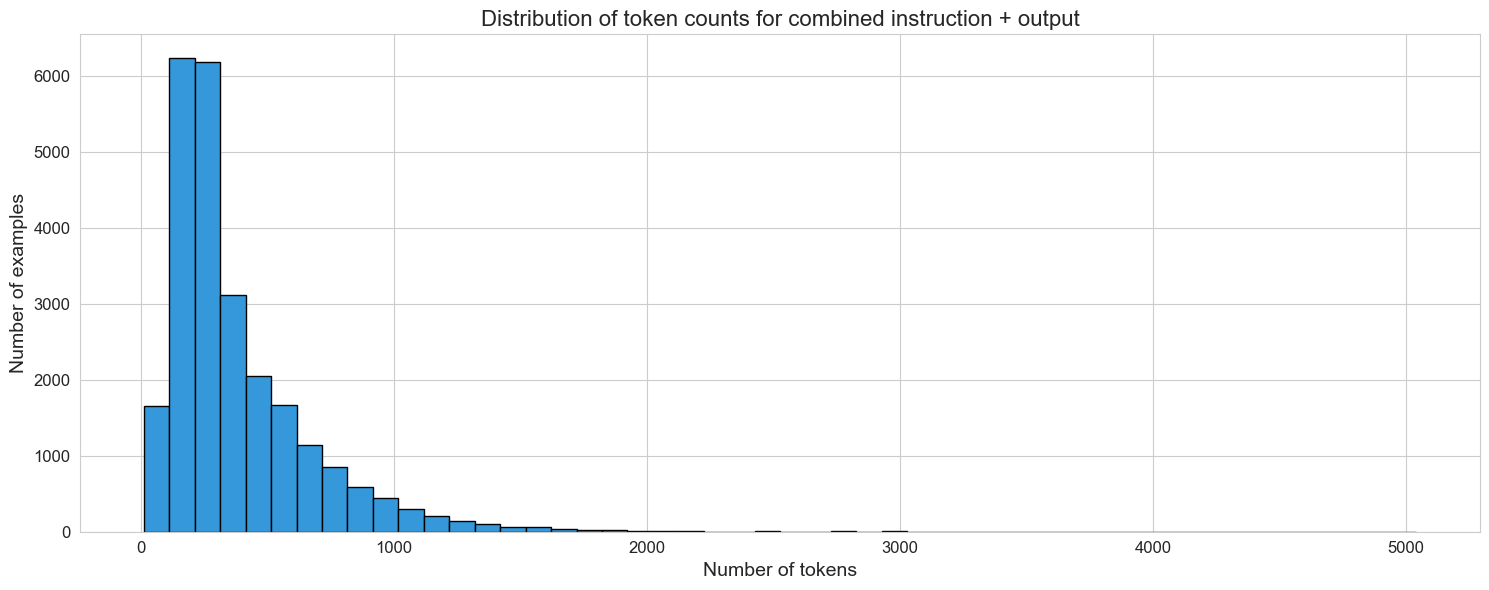

In [13]:
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")

## 3. Filter out rows with more than 2048 tokens

We can remove samples with more than 2048 tokens (max context size of Llama 2 by default = 4096).

Number of valid rows: 24895
Removing 31 rows...


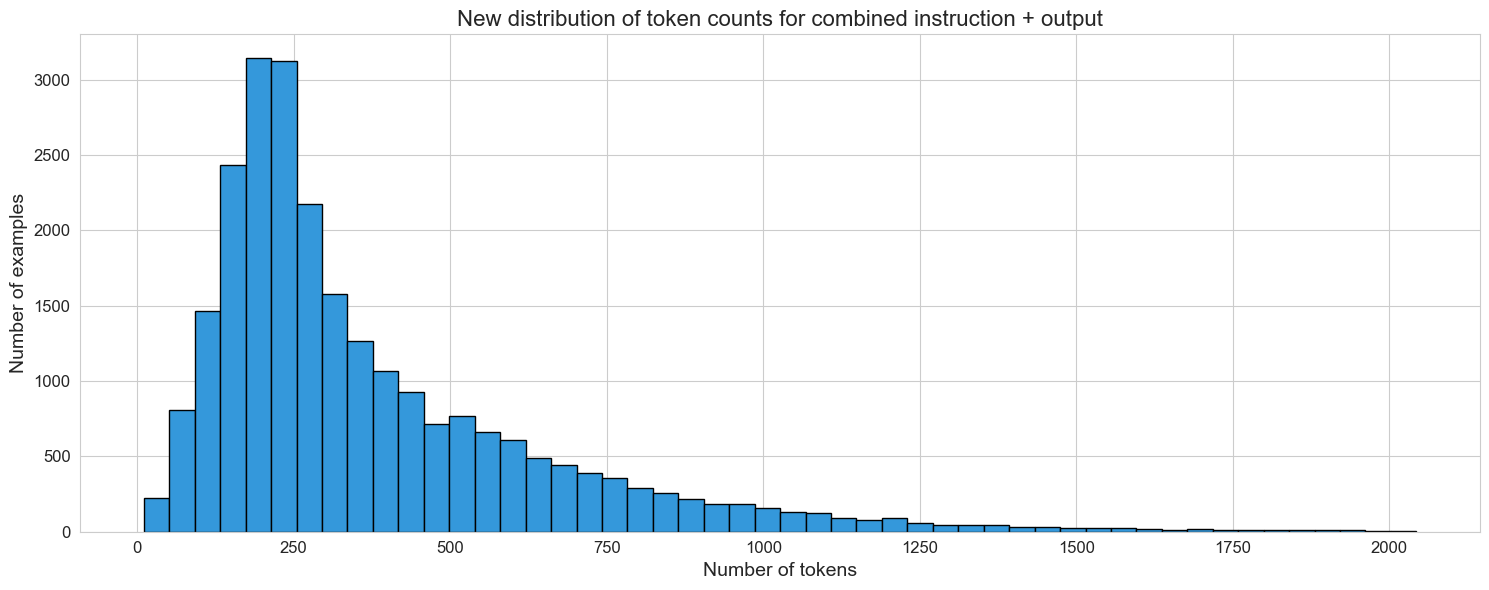

In [14]:
# Filter out rows with more than 2048 tokens
valid_indices = [i for i, count in enumerate(combined_token_counts) if count <= 2048]
print(f"Number of valid rows: {len(valid_indices)}")
print(f"Removing {len(dataset['train']) - len(valid_indices)} rows...")

# Extract valid rows based on indices
dataset['train'] = dataset['train'].select(valid_indices)

# Get token counts for valid rows
token_counts = [combined_token_counts[i] for i in valid_indices]

plot_distribution(token_counts, "New distribution of token counts for combined instruction + output")

## 4. Near-deduplication using embeddings

How to choose the embedding model? Check the [MTEB leaderboard](https://huggingface.co/spaces/mteb/leaderboard). In this example, we're not using the best embedding model because it would take too long.

![](https://i.imgur.com/Fbx1Ivz.png)

In [15]:
def deduplicate_dataset(dataset: Dataset, model: str, threshold: float):
    # Initialize the SentenceTransformer model for converting text to embeddings
    sentence_model = SentenceTransformer(model)
    
    # Extract the output texts from the training dataset
    outputs = [example["output"] for example in dataset['train']]
    
    print("Converting text to embeddings...")
    
    # Convert the output texts to embeddings using the SentenceTransformer model
    embeddings = sentence_model.encode(outputs, show_progress_bar=True)
    
    # Get the dimension of the embeddings
    dimension = embeddings.shape[1]
    
    # Create a FAISS index for searching similar embeddings using Inner Product (cosine similarity)
    index = faiss.IndexFlatIP(dimension)
    
    # We normalize embeddings to unit length for cosine similarity to ensure that the similarity measurement is based solely on the direction of the vectors, not their magnitude (in fact cosine similarity is the ratio between a dot product and a euclidean distance norm)
    normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    
    # Add the normalized embeddings to the FAISS index
    index.add(normalized_embeddings)
    
    print("Filtering out near-duplicates...")
    
    # Search the FAISS index to find the nearest neighbors for each embedding
    D, I = index.search(normalized_embeddings, k=2) # k=2 means that for each embedding, the search will return the two closest neighbors based on cosine similarity
#     D: This is the matrix containing the distances (or similarities) between each queried embedding and its k-nearest neighbors. In your case, it holds the cosine similarities since you normalized the embeddings.
#     I: This is the matrix containing the indices of the k-nearest neighbors for each queried embedding.
# So, for each embedding:
# D[i, 0]: Cosine similarity of the embedding with itself (always 1 for normalized vectors).
# D[i, 1]: Cosine similarity with the closest neighbor.
# I[i, 0]: Index of the embedding itself. (== i)
# I[i, 1]: Index of the closest neighbor.
    
    # Initialize a list to keep track of indices of embeddings to retain
    to_keep = []
    
    # Iterate over each embedding to filter out near-duplicates
    for i in tqdm(range(len(embeddings)), desc="Filtering"):
        # If the cosine similarity of the second closest vector is above the threshold
        if D[i, 1] >= threshold:
            # Get the index of the nearest neighbor
            nearest_neighbor = I[i, 1]
            # If neither the current item nor its nearest neighbor is already in the to_keep list
            if i not in to_keep and nearest_neighbor not in to_keep:
                # Add the current item to the to_keep list
                to_keep.append(i)
        else:
            # If the similarity is below the threshold, always keep the current item
            to_keep.append(i)
    
    # Select the items in the dataset that are in the to_keep list
    dataset = dataset['train'].select(to_keep)
    
    # Return the deduplicated dataset wrapped in a DatasetDict
    return DatasetDict({"train": dataset})

# Example usage of the deduplicate_dataset function with a dataset, model, and threshold
deduped_dataset = deduplicate_dataset(dataset, "thenlper/gte-large", 0.95)


C:\Users\Alienware\AppData\Roaming\Python\Python310\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Alienware\.cache\huggingface\hub\models--thenlper--gte-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\Users\Alienware\AppData\Roaming\Python\Python310\site-packages\huggingface_hub\file_downloa

Converting text to embeddings...


Batches:   0%|                                                                                 | 0/778 [00:00<?, ?it/s]C:\Users\Alienware\miniconda3\envs\py310\lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Batches: 100%|███████████████████████████████████████████████████████████████████████| 778/778 [41:47<00:00,  3.22s/it]


Filtering out near-duplicates...


Filtering: 100%|███████████████████████████████████████████████████████████████| 24895/24895 [00:05<00:00, 4214.58it/s]


In [16]:
print(f"Number of samples in the original dataset: {len(dataset['train'])}")
print(f"Number of samples in the deduped dataset: {len(deduped_dataset['train'])}")
print(f"Number of samples that were removed: {len(dataset['train']) - len(deduped_dataset['train'])}")

Number of samples in the original dataset: 24895
Number of samples in the deduped dataset: 19503
Number of samples that were removed: 5392


DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'data_source'],
        num_rows: 19503
    })
})


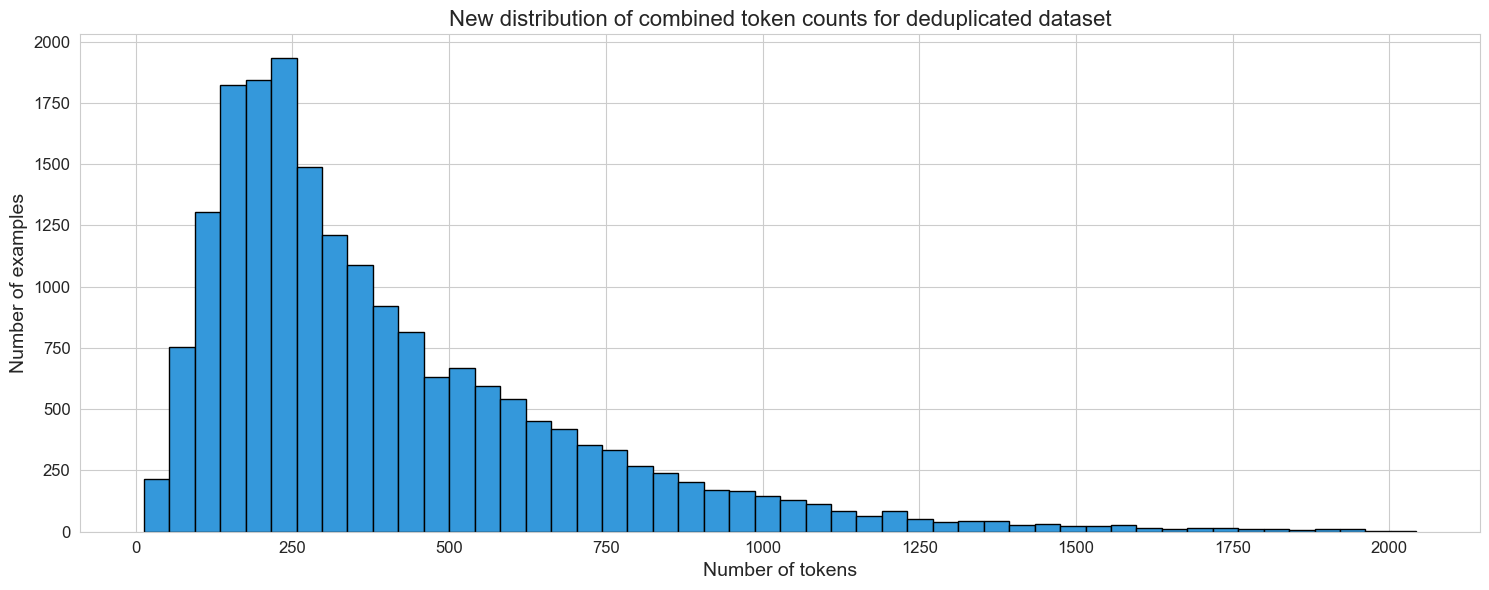

In [19]:
print(deduped_dataset)

# chck again the distribution
# 2. Tokenize each row and count the number of tokens
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in deduped_dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in deduped_dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

plot_distribution(combined_token_counts, "New distribution of combined token counts for deduplicated dataset")

## 5. Top-k sampling

Only keep the top k samples with the most tokens.

In [20]:
# Get the top k rows with the most tokens
def get_top_k_rows(dataset, token_counts, k):
    # Sort by descending token count and get top k indices
    sorted_indices = sorted(range(len(token_counts)), key=lambda i: token_counts[i], reverse=True)
    top_k_indices = sorted_indices[:k]

    # Extract top k rows
    top_k_data = {
        "instruction": [dataset['train'][i]["instruction"] for i in top_k_indices],
        "output": [dataset['train'][i]["output"] for i in top_k_indices]
    }

    return Dataset.from_dict(top_k_data)

k = 1000  # You can adjust this value as needed
top_k_dataset = get_top_k_rows(deduped_dataset, combined_token_counts, k) # we sort by the combined token count (after deduplication)

# Save these rows in a Dataset object with a 'train' split
dataset = DatasetDict({"train": top_k_dataset})

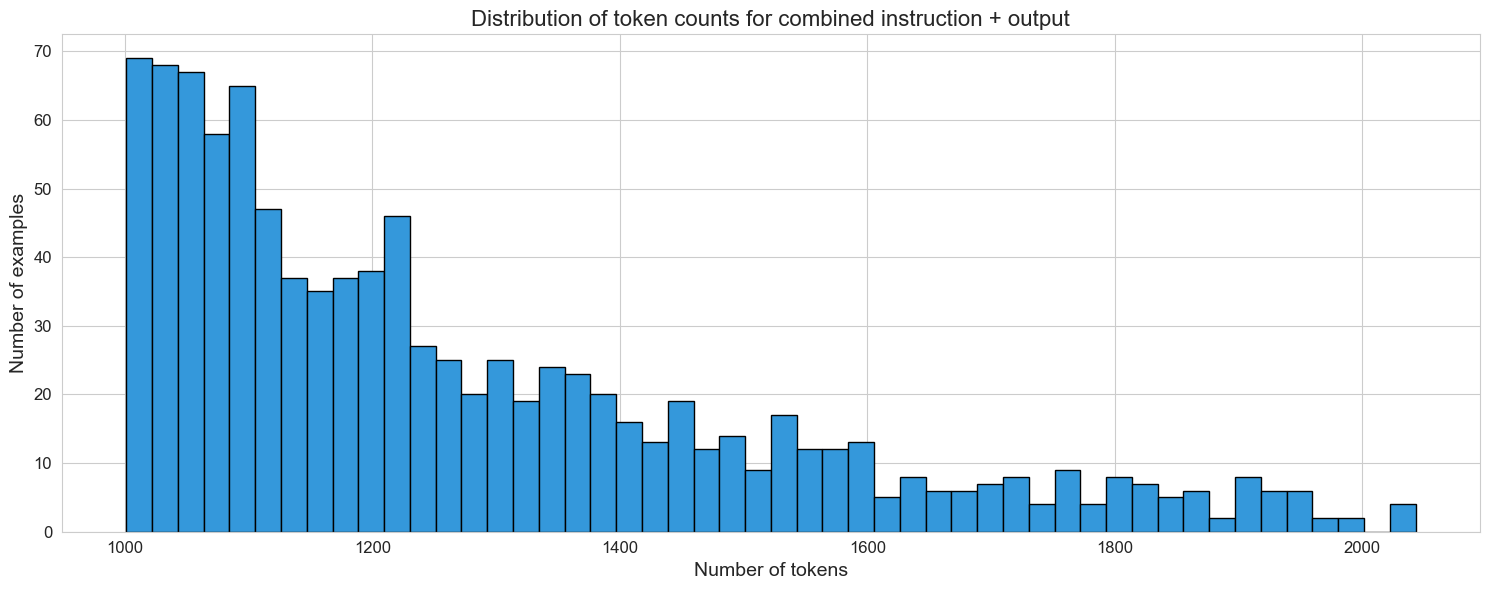

In [22]:
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

# Plot the distribution of token counts
# plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
# plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")

In [23]:
# Read as pandas DataFrame
dataset['train'].to_pandas()

,instruction,output
0,Let's come up with a rich and complex alien wo...,Planet Name: Xylothar\n\nXylothar is a diverse...
1,"Let\n$$p(x,y) = a_0 + a_1x + a_2y + a_3x^2 + a...","Observe that \begin{align*}\np(0,0) &= a_0 = ..."
2,"Given the code below, refactor it, add comment...",Here is the refactored and commented version:\...
3,Find the area of the region described by $x \g...,"Let $n = \lfloor x \rfloor,$ and let $\{x\} = ..."
4,Let $P$ be the plane passing through the origi...,Let $\mathbf{v} = \begin{pmatrix} x \\ y \\ z ...
...,...,...
995,Hello. My name is Mike. I have a message left ...,"Hello Mike, it's nice to meet you. As an AI la..."
996,"Given a prime $p$ and an integer $a$, we say t...","To find the primitive roots $\pmod 7$, I need ..."
997,Let $f$ be defined by \[f(x) = \left\{\n\begi...,The number $f^{-1}(-3)$ is the value of $x$ su...
998,"BEGININPUT\nBEGINCONTEXT\ndate: August 5, 2021...",Dr. Eleanor Thompson's study found that partic...


## 6. Chat templates

We need to define a **chat template**, which formats the instructions and responses in a way that is suitable for the model. Here's an example of raw instructions and responses from a [Hugging Face blog post](https://huggingface.co/blog/chat-templates):

```
[
    {"role": "user", "content": "Hi there!"},
    {"role": "assistant", "content": "Nice to meet you!"}
]
```

There are different ways to format it. The most straightforward one would be:

```
User: Hey there!
Assistant: Nice to meet you!
```

In the case of Llama 2, the authors used the following template for the **chat models**:

```
<s>[INST] <<SYS>>
System prompt
<</SYS>>

User prompt [/INST] Model answer </s>
```

Currently, the most popular and standardized chat template is ChatML from OpenAI, which looks like this:

```
<|im_start|>user
Hey there!<|im_end|>
<|im_start|>assistant
Nice to meet you!<|im_end|>
```

The impact of chat templates on the performance of the model is unclear. In most cases, we fine-tune base models that have not been trained with a particular template, which is also why there's no clear standard. However, they are important as they can cause many issues and limit the compatibility of your models.

In [25]:
def chat_template(example):
    example["instruction"] = f"### Instruction:\n{example['instruction']}\n\n### Response:\n"
    return example

dataset = dataset.map(chat_template)

Map: 100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 12883.91 examples/s]


In [26]:
dataset['train'].to_pandas()

,instruction,output
0,### Instruction:\nLet's come up with a rich an...,Planet Name: Xylothar\n\nXylothar is a diverse...
1,"### Instruction:\nLet\n$$p(x,y) = a_0 + a_1x +...","Observe that \begin{align*}\np(0,0) &= a_0 = ..."
2,"### Instruction:\nGiven the code below, refact...",Here is the refactored and commented version:\...
3,### Instruction:\nFind the area of the region ...,"Let $n = \lfloor x \rfloor,$ and let $\{x\} = ..."
4,### Instruction:\nLet $P$ be the plane passing...,Let $\mathbf{v} = \begin{pmatrix} x \\ y \\ z ...
...,...,...
995,### Instruction:\nHello. My name is Mike. I ha...,"Hello Mike, it's nice to meet you. As an AI la..."
996,### Instruction:\nGiven a prime $p$ and an int...,"To find the primitive roots $\pmod 7$, I need ..."
997,### Instruction:\nLet $f$ be defined by \[f(x...,The number $f^{-1}(-3)$ is the value of $x$ su...
998,### Instruction:\nBEGININPUT\nBEGINCONTEXT\nda...,Dr. Eleanor Thompson's study found that partic...


In [32]:
# Save the dataset to disk
dataset.save_to_disk(os.getcwd())

Saving the dataset (1/1 shards): 100%|███████████████████████████████████| 1000/1000 [00:00<00:00, 27792.49 examples/s]


In [27]:
# # Optional: push to Hugging Face Hub
# dataset.push_to_hub("mini-platypus", token=hf_token)